In [5]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import KFold, train_test_split
from PIL import Image
import matplotlib.pyplot as plt

# データへのパスを指定
folder_path = 'C:/Users/Atsuya_Watanabe/research/2408PeachDetect/20240724AKATSUKI/HyperspectoralCameraData/processed_images_'
folder_path_1 = 'C:/Users/Atsuya_Watanabe/research/2408PeachDetect/20240724AKATSUKI/HyperspectoralCameraData/processed_images_935nm'
csv_path = 'C:/Users/Atsuya_Watanabe/research/2408PeachDetect/20240724AKATSUKI/SugerContentData/20240726SugercontentDestructive.csv'

# 画像を読み込む関数
def load_images_and_labels_from_folder(folder, csv_path, target_size=(128, 128)):
    df = pd.read_csv(csv_path)
    images = []
    labels = []
    for index, row in df.iterrows():
        filename = row['filename']
        label = row['label']
        img_path = os.path.join(folder, filename)
        if os.path.exists(img_path):
            img = Image.open(img_path).convert('RGB').resize(target_size)  # ここで画像をリサイズ
            if img is not None:
                images.append(np.array(img))
                labels.append(label)
    return np.array(images), np.array(labels)
#単体のCNNの場合
X_1, y_1 = load_images_and_labels_from_folder(folder_path_1, csv_path)

# 全体のデータを用いたCNNの場合
X = np.empty((0, 128, 128, 3))  # 空の4次元配列 (画像数, 高さ, 幅, チャンネル)
y = np.empty((0,))  # 空の1次元配列（ラベル）

for i in range(400, 930, 5):
    
    folder_path_i = folder_path + str(i) + "nm"  # 数値を文字列に変換してパスを構築
    images, labels = load_images_and_labels_from_folder(folder_path_i, csv_path)

    # 配列を連結
    X = np.concatenate((X, images), axis=0)
    y = np.concatenate((y, labels), axis=0)

    ########

for i in range(935, 1701, 5):
    
    folder_path_i = folder_path + str(i) + "nm"  # 数値を文字列に変換してパスを構築
    images, labels = load_images_and_labels_from_folder(folder_path_i, csv_path)

    # 配列を連結
    X = np.concatenate((X, images), axis=0)
    y = np.concatenate((y, labels), axis=0)

    #######

# データを訓練データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, test_size=0.2, random_state=42)

X_train = np.concatenate((X_train, X), axis = 0)
y_train = np.concatenate((y_train, y), axis = 0)

# 画像の正規化
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# K分割交差検証
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
val_scores = []

for train_index, val_index in kf.split(X_train):
    print(f'Fold {fold}')
    fold += 1

    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # モデルを構築
    model = keras.Sequential([
        keras.layers.Input(shape=(128, 128, 3)),
        keras.layers.Conv2D(32, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(128, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(1)  # 回帰のための出力は1ユニット
    ])
     # 最適化手法と損失関数を指定してコンパイル
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

    # モデルの訓練
    history = model.fit(X_train_fold, y_train_fold, epochs=20, validation_data=(X_val_fold, y_val_fold), batch_size=32)

    # モデルの評価
    val_loss, val_mae = model.evaluate(X_val_fold, y_val_fold)
    val_scores.append(val_mae)
    print(f'Validation MAE for fold {fold-1}: {val_mae}')



Fold 1
Epoch 1/20
326/326 ━━━━━━━━━━━━━━━━━━━━ 28s 83ms/step - loss: 14.4766 - mae: 2.6090 - val_loss: 2.5913 - val_mae: 1.3320
Epoch 2/20
326/326 ━━━━━━━━━━━━━━━━━━━━ 27s 82ms/step - loss: 2.6672 - mae: 1.3329 - val_loss: 2.2954 - val_mae: 1.2202
Epoch 3/20
326/326 ━━━━━━━━━━━━━━━━━━━━ 27s 82ms/step - loss: 2.5287 - mae: 1.2813 - val_loss: 1.6234 - val_mae: 1.0409
Epoch 4/20
326/326 ━━━━━━━━━━━━━━━━━━━━ 27s 82ms/step - loss: 1.7996 - mae: 1.0707 - val_loss: 1.9784 - val_mae: 1.1034
Epoch 5/20
326/326 ━━━━━━━━━━━━━━━━━━━━ 27s 82ms/step - loss: 1.5339 - mae: 0.9719 - val_loss: 1.2398 - val_mae: 0.8610
Epoch 6/20
326/326 ━━━━━━━━━━━━━━━━━━━━ 26s 80ms/step - loss: 1.2306 - mae: 0.8614 - val_loss: 0.9531 - val_mae: 0.7567
Epoch 7/20
326/326 ━━━━━━━━━━━━━━━━━━━━ 27s 82ms/step - loss: 0.8509 - mae: 0.7045 - val_loss: 0.6525 - val_mae: 0.5822
Epoch 8/20
326/326 ━━━━━━━━━━━━━━━━━━━━ 26s 81ms/step - loss: 0.6531 - mae: 0.6075 - val_loss: 0.5678 - val_mae: 0.5421
Epoch 9/20
326/326 ━━━━━━━━━━━━━

In [6]:
# 交差検証の平均スコアを計算
average_val_score = np.mean(val_scores)
print(f'\nAverage Validation MAE: {average_val_score}')

# テストデータで最終評価
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f'\nTest MAE: {test_mae}')


Average Validation MAE: 0.27217278480529783
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.7816 - mae: 0.7304

Test MAE: 0.7304450273513794


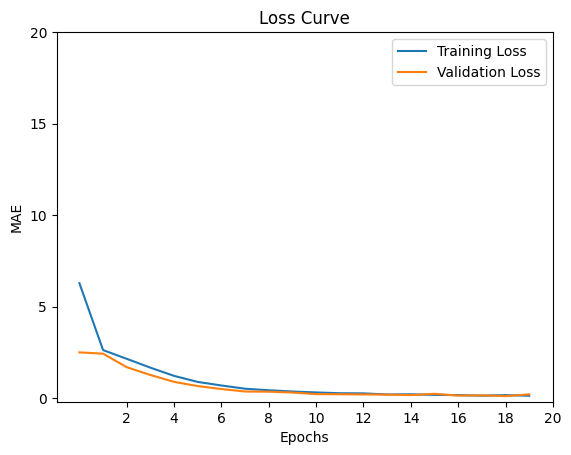

In [7]:
# 損失曲線をプロット
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.xticks([2,4,6,8,10,12,14,16,18,20])
plt.yticks([0, 5, 10, 15, 20])
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


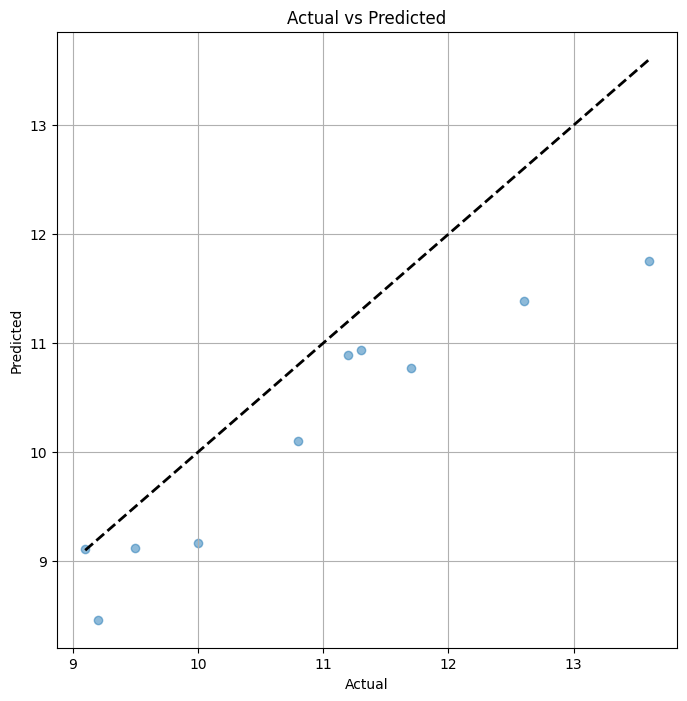

[[11.386152]
 [ 9.111432]
 [ 9.124431]
 [ 9.169392]
 [11.757963]
 [ 8.462525]
 [10.939254]
 [10.895407]
 [10.771166]
 [10.100693]] 

[12.6  9.1  9.5 10.  13.6  9.2 11.3 11.2 11.7 10.8] 

Correlation coefficient: 0.9544886350862399
Mean Absolute Error (MAE): 0.730444984436035


In [8]:
from sklearn.metrics import mean_absolute_error

# テストデータに対する予測値を取得
y_pred = model.predict(X_test)

# 実際の値と予測値の相関図をプロット
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.grid(True)
plt.show()

print(y_pred, '\n')
print(y_test, '\n')

# 実際の値と予測値の相関係数を計算
correlation_matrix = np.corrcoef(y_test, y_pred[:, 0])
correlation_coefficient = correlation_matrix[0, 1]
print('Correlation coefficient:', correlation_coefficient)

# MAE（平均絶対誤差）を計算
mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error (MAE):', mae)
